In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from torch import distributions
from torch import nn
from torch.nn.parameter import Parameter
import torchvision as tv
import torchvision.transforms as tr
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from core import networks
from core import toy_data
from core import models

In [3]:
device = torch.device('cpu')

In [4]:
def get_data(use_logit, data_name, batch_size):
    if use_logit:
        transform = tr.Compose([tr.ToTensor(), lambda x: x * (255. / 256.) + (torch.rand_like(x) / 256.), logit])
    else:
        transform = tr.Compose([tr.ToTensor(), lambda x: x * (255. / 256.) + (torch.rand_like(x) / 256.)])
    if data_name == "mnist":
        dset_train = tv.datasets.MNIST(root="../data", train=True, transform=transform, download=False)
        dset_test = tv.datasets.MNIST(root="../data", train=False, transform=transform, download=False)
    elif data_name == "fashionmnist":
        dset_train = tv.datasets.FashionMNIST(root="../data", train=True, transform=transform, download=False)
        dset_test = tv.datasets.FashionMNIST(root="../data", train=False, transform=transform, download=False)
    else:
        assert False, "wrong dataset"

    dload_train = DataLoader(dset_train, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    dload_test = DataLoader(dset_test, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    return dload_train, dload_test

In [5]:
dload_train, dload_test = get_data(False, 'mnist', 1000)
for train_samples, _ in dload_train:
    init_batch = train_samples.view(-1, 1, *data_shape)
    break
mu, sigma = init_batch.mean(), init_batch.std()
base_dist = distributions.Normal(mu, sigma)

NameError: name 'data_shape' is not defined

In [12]:
def logit_inv(x, alpha=1e-6):
    x = torch.exp(x)/(1+torch.exp(x))
    x = (x - alpha)/(1 - 2 * alpha)
    return x

data_shape = (1, 28, 28)
data_dim = 28*28

base_dist = distributions.Normal(torch.zeros(1).sum(), torch.ones(1).sum())
net = networks.MNISTSmallConvNet(nc=64, relu=True)
ebm = models.EBM(net, base_dist=None).to(device)
ebm.load_state_dict(torch.load('../checkpoints/baseline_DM_mnist', map_location=device)['ebm_state_dict'])

<All keys matched successfully>

In [39]:
dt = 1e-1
sigma = np.sqrt(dt)
n_samples = 10
n_iter = 1000
beta_schedule = np.linspace(0.0,1.0, n_iter)

init_dist = distributions.Normal(torch.zeros(1).sum(), torch.ones(1).sum())
samples = init_dist.sample([n_samples, *data_shape])
samples = torch.autograd.Variable(samples, requires_grad=True)
log_w = torch.zeros(n_samples)
log_prob = lambda x, beta: (beta*(-ebm(x))+(1-beta)*init_dist.log_prob(x.view(-1,data_dim)).sum(1))
acceptance_rate = 0.0
for i in range(1,n_iter):
    beta, beta_prev = beta_schedule[i], beta_schedule[i-1]
    with torch.no_grad():
        log_w += log_prob(samples,beta) - log_prob(samples,beta_prev)
    grad = torch.autograd.grad(log_prob(samples, beta).sum(), samples)[0].detach()
    proposals = samples.data + dt/2. * grad + torch.randn_like(samples) * sigma
    proposals = torch.autograd.Variable(proposals, requires_grad=True)
    grad_p = torch.autograd.grad(log_prob(proposals, beta).sum(), proposals)[0].detach()
    with torch.no_grad():
        log_P = log_prob(proposals.data, beta)-log_prob(samples.data, beta)
        log_P += - 0.5/sigma**2*((samples-(proposals+dt/2.*grad_p))**2).view(-1, data_dim).sum(1)
        log_P += + 0.5/sigma**2*((proposals-(samples+dt/2.*grad))**2).view(-1, data_dim).sum(1)
        log_U = torch.log(torch.rand_like(log_P))
    accept_mask = log_P > log_U
    acceptance_rate += accept_mask.float().mean()
    samples.data[accept_mask] = proposals.data[accept_mask]
acceptance_rate /= n_iter
samples = logit_inv(samples.detach())
Z = torch.exp(log_w).mean()
print(acceptance_rate, Z)

tensor(0.9337) tensor(inf)


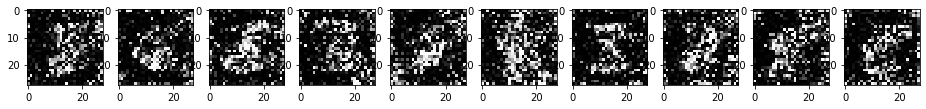

In [40]:
figsize(16,3)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(samples.detach().numpy()[i].reshape(data_shape[1:]), cmap='gray', interpolation='nearest')

In [99]:
log_w

tensor([6566.2363, 6469.1924, 6583.7383, 6561.4756, 6262.1924, 6592.9668,
        6078.8643, 6100.2646, 6046.3540, 6771.9155])

In [94]:
dt = 1e-1
sigma = np.sqrt(dt)
n_samples = 10
n_iter = 10000
beta_schedule = np.linspace(0.0,1.0, n_iter)

init_dist = distributions.Normal(torch.zeros(1).sum(), torch.ones(1).sum())
samples = init_dist.sample([n_samples, *data_shape])
samples = torch.autograd.Variable(samples, requires_grad=True)
log_w = torch.zeros(n_samples)
log_w += -data_dim/2.*np.log(2*np.pi)
log_prob = lambda x, beta: (beta*(-ebm(x))+(1-beta)*init_dist.log_prob(x.view(-1,data_dim)).sum(1))
dEdt = lambda x: (ebm(x)+init_dist.log_prob(x.view(-1,data_dim)).sum(1))
for i in range(1,n_iter):
    beta, beta_prev = beta_schedule[i], beta_schedule[i-1]
    with torch.no_grad():
        log_w += log_prob(samples,beta) - log_prob(samples,beta_prev)
    grad = torch.autograd.grad(dEdt(samples).sum(), samples)[0].detach()
    samples.data += -(beta-beta_prev)*grad
samples = logit_inv(samples.detach())
Z = torch.exp(log_w).mean()
print(Z.numpy())

0.0


In [95]:
log_w

tensor([-2632.4644, -2638.9338, -2166.2974, -1951.5310, -2546.7866, -2005.2664,
        -2579.5415, -2405.6152, -2417.4802, -2348.9585])

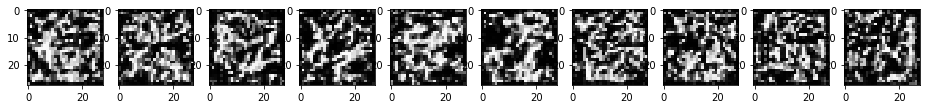

In [96]:
figsize(16,3)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(samples.detach().numpy()[i].reshape(data_shape[1:]), cmap='gray', interpolation='nearest')

In [27]:
dt = 1e-1
n_samples = 10
samples = torch.randn((n_samples,1,28,28))
samples = torch.autograd.Variable(samples, requires_grad=True)
samples = ebm.sample(samples, dt=1e0, sigma=0.005, n_steps=1000)
samples = logit_inv(samples.detach())

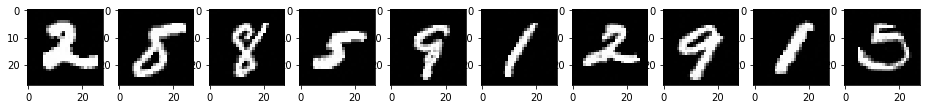

In [28]:
figsize(16,3)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(samples.detach().numpy()[i].reshape(data_shape[1:]), cmap='gray', interpolation='nearest')